### Goals

Debug the current svm pipeline by 
1) Loading the data in the same way and plotting it
2) fiddling with hyperparams

In [2]:
import anndata as ad
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import json
import ccf_streamlines.projection as ccfproj
from datasets import load_from_disk
import yaml

import sys
# import ../utils
sys.path.append('../')

from utils import reflect_points_to_left


In [3]:
root_path = os.environ["ROOT_DATA_PATH"]
ccf_files_path = os.path.join(root_path, "CCF_files")



In [4]:
bf_boundary_finder = ccfproj.BoundaryFinder(
    projected_atlas_file=    os.path.join(ccf_files_path,"flatmap_butterfly.nrrd"),
    labels_file=    os.path.join(ccf_files_path,"labelDescription_ITKSNAPColor.txt"),
)

bf_left_boundaries_flat = bf_boundary_finder.region_boundaries()
bf_right_boundaries_flat = bf_boundary_finder.region_boundaries(
    hemisphere='right_for_both',
    view_space_for_other_hemisphere='flatmap_butterfly',
)

In [5]:
# First, create the master color mapping (before any loops)
def create_master_colormap(folds_range, group_size, val_or_test):
    all_categories = set()
    label_names = None
    for f in folds_range:
        predictions_path = os.path.join(root_path, f"barseq/annotation/fold{f}_animal_name_class_weights2_{group_size}/{val_or_test}_brain_predictions_cells.npy")
        pred_dict = np.load(predictions_path, allow_pickle=True).item()
        all_categories.update(np.unique(pred_dict['labels']))
        all_categories.update(np.unique(pred_dict['predictions']))
        if label_names is None and 'label_names' in pred_dict:
            label_names = pred_dict['label_names']
    
    # Convert to sorted list for consistent ordering
    all_categories = sorted(list(all_categories))
    
    # Create extended colormap by combining multiple colorschemes
    colormaps = ['tab20', 'tab20b', 'tab20c']
    colors = np.vstack([plt.cm.get_cmap(cmap)(np.linspace(0, 1, 20)) for cmap in colormaps])
    
    # Map categories to colors
    color_indices = np.arange(len(all_categories)) % len(colors)
    color_map = dict(zip(all_categories, colors[color_indices]))
    
    return color_map, label_names

def plot_scatter_style(x, y, labels, preds, color_map, bf_left_boundaries_flat, alpha=0.5):
    """Plot the scatter-style visualization with three panels"""
    f, ax = plt.subplots(1, 3, figsize=(15, 5))
    
    # Panel 1: Labels
    colors_labels = np.array([color_map[label] for label in labels])
    ax[0].scatter(x, y, color=colors_labels, alpha=alpha, linewidths=0, s=5)
    ax[0].set_title("Area labels")
    
    # Panel 2: Predictions
    colors_preds = np.array([color_map[pred] for pred in preds])
    ax[1].scatter(x, y, color=colors_preds, alpha=alpha, linewidths=0, s=5)
    ax[1].set_title("Area predictions")
    
    # Panel 3: Errors
    misclassified = labels != preds
    ax[2].scatter(x[misclassified], y[misclassified], color='r', alpha=alpha, linewidths=0, s=5)
    ax[2].set_title("Errors")
    
    # Common styling for all panels
    for a in ax:
        a.grid(False)
        for k, boundary_coords in bf_left_boundaries_flat.items():
            a.plot(*boundary_coords.T, c="k", lw=0.5)
        a.axis('off')
        a.set_aspect('equal')
        a.set_ylim(a.get_ylim()[::-1])
    
    plt.tight_layout()
    return f, ax

import matplotlib as mpl

def create_hexbin_categorical(x, y, labels, label_map=None, gridsize=30):
    """
    Create a hexagonal binning plot for categorical data.
    
    Parameters:
    -----------
    x : array-like
        x-coordinates of the points
    y : array-like
        y-coordinates of the points
    labels : array-like
        categorical labels for each point
    label_map : dict, optional
        mapping from numerical IDs to string labels for legend
    gridsize : int, optional
        number of hexagons in the x-direction
    
    Returns:
    --------
    fig : matplotlib figure
    ax : matplotlib axes
    hexbin_data : pandas DataFrame
    """
    # Convert data to DataFrame
    df = pd.DataFrame({
        'x': x,
        'y': y,
        'label': labels
    })
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Calculate data extent
    xmin, xmax = x.min(), x.max()
    ymin, ymax = y.min(), y.max()
    
    # Create a temporary hexbin to get the hex locations and sizes
    hb = ax.hexbin(x, y, gridsize=gridsize, extent=(xmin, xmax, ymin, ymax), visible=False)
    
    # Get hex centers and corners
    hex_centers = hb.get_offsets()
    hex_path = hb.get_paths()[0]
    
    # Function to find modal category
    def get_modal_category(points):
        if len(points) == 0:
            return np.nan
        values, counts = np.unique(points, return_counts=True)
        if len(counts) == 0:
            return np.nan
        return values[np.argmax(counts)]
    
    hex_stats = []
    for i, center in enumerate(hex_centers):
        # Transform the generic hex path to this specific hexagon's position
        vertices = hex_path.vertices + center
        
        # Find points within this hexagon
        mask = mpl.path.Path(vertices).contains_points(df[['x', 'y']])
        if mask.any():
            points_in_hex = df[mask]
            modal_cat = get_modal_category(points_in_hex['label'])
            hex_stats.append({
                'hex_id': i,
                'modal_category': modal_cat,
                'count': len(points_in_hex),
                'center_x': center[0],
                'center_y': center[1]
            })
    
    hex_stats = pd.DataFrame(hex_stats)
    
    # Create extended colormap by combining multiple colorschemes
    colormaps = ['tab20', 'tab20b', 'tab20c']
    colors = np.vstack([plt.cm.get_cmap(cmap)(np.linspace(0, 1, 20)) for cmap in colormaps])

    # Get unique categories and map to extended colors
    unique_categories = np.unique(labels[~pd.isna(labels)])
    n_categories = len(unique_categories)
    color_indices = np.arange(n_categories) % len(colors)
    category_colors = dict(zip(unique_categories, colors[color_indices]))
    
    # Create collection of hexagons
    patches = []
    colors = []
    for _, row in hex_stats.iterrows():
        center = (row['center_x'], row['center_y'])
        vertices = hex_path.vertices + center
        patch = mpl.patches.Polygon(vertices)
        patches.append(patch)
        colors.append(category_colors[row['modal_category']])
    
    # Plot hexagons
    collection = mpl.collections.PatchCollection(
        patches, 
        facecolors=colors,
        edgecolors='white',
        linewidth=0.5,
        alpha=0.7
    )
    ax.add_collection(collection)
    
    # Set plot limits
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    
    # Add legend with mapped labels
    legend_elements = [plt.Rectangle((0, 0), 1, 1, facecolor=color, alpha=0.7)
                      for color in category_colors.values()]
    
    if label_map is not None:
        legend_labels = [label_map.get(int(cat), str(cat)) for cat in category_colors.keys()]
    else:
        legend_labels = [str(cat) for cat in category_colors.keys()]
    
    ax.legend(legend_elements, legend_labels,
             title='Categories', loc='center left', bbox_to_anchor=(1, 0.5))
        
    # Set equal aspect ratio
    ax.set_aspect('equal')

    ax.grid(False)
    for k, boundary_coords in bf_left_boundaries_flat.items():
        ax.plot(*boundary_coords.T, c="k", lw=0.5)

    ax.axis('off')
    # reverse y-axis
    ax.set_ylim(ax.get_ylim()[::-1])
    
    # Adjust layout to prevent legend overlap
    plt.tight_layout()


    
    return fig, ax, hex_stats

def plot_hexbin_style(x, y, labels, preds, color_map, bf_left_boundaries_flat, label_names, gridsize=50):
    """Plot the hexbin-style visualization"""
    fig, ax, hex_stats = create_hexbin_categorical(
        x, y, preds,
        label_map={int(k): v for k, v in label_names.items()} if label_names else None,
        gridsize=gridsize
    )
    return fig, ax, hex_stats

# Main execution loop
    # Create master colormap
   


/tmp/ipykernel_677252/3704096741.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = np.vstack([plt.cm.get_cmap(cmap)(np.linspace(0, 1, 20)) for cmap in colormaps])


Accuracy 61.3608549069


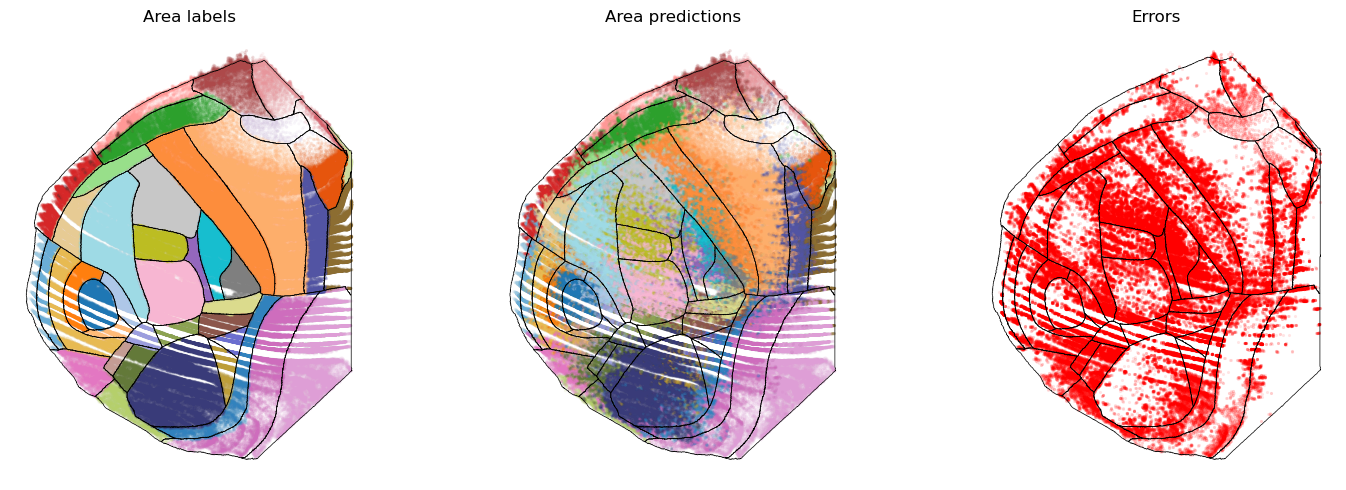

In [6]:
group_size=32
val_or_test = "test"  
fold=3
color_map, label_names = create_master_colormap(range(4), group_size, val_or_test)


# Load data
predictions_path = os.path.join(root_path,f"barseq/annotation/fold{fold}_animal_name_class_weights2_{group_size}/{val_or_test}_brain_predictions_cells.npy")
pred_dict = np.load(predictions_path, allow_pickle=True).item()
dataset = load_from_disk(os.path.join(root_path, f"barseq/Chen2023/train_test_barseq_all_exhausted_fold{fold}.dataset"))

# Prepare data
labels = np.array(pred_dict['labels']).flatten()
preds = np.array(pred_dict['predictions']).flatten()
indices = np.array(pred_dict['indices'])#[:,0].flatten()

s=1
xyz = np.array(dataset['train' if val_or_test == "validation" else 'test'][indices]['CCF_streamlines'])
xyz = reflect_points_to_left(xyz)
x, y = xyz[::s,0], xyz[::s,1]
labels, preds = labels[::s], preds[::s]

# Calculate accuracy
acc = (preds == labels).sum() / len(labels)
print("Accuracy", 100*acc)

# # Plot based on style
fig, ax = plot_scatter_style(x, y, labels, preds, color_map, bf_left_boundaries_flat,.1)
# plt.savefig(f'test_enucleated_single-cell-preds-{val_or_test}-{group_size}.png', dpi=300)
plt.show()
# fig, ax, _ = plot_hexbin_style(x, y, labels, preds, color_map, bf_left_boundaries_flat, label_names)
# # plt.savefig(f'test_enucleated_single-cell-preds-{val_or_test}-{group_size}-hex.png', dpi=300)
# plt.show()


In [45]:
import numpy as np
import matplotlib.pyplot as plt
from cuml.svm import SVC

import logging
from typing import Dict, List, Optional

from matplotlib.colors import ListedColormap
import ccf_streamlines.projection as ccfproj
import os

logging.basicConfig(level=logging.ERROR)
logger = logging.getLogger(__name__)

from typing import Optional, Union, Tuple, Callable, Dict, Any, List, Literal
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.base import BaseEstimator
from scipy import ndimage

import warnings
from tqdm import tqdm

# Suppress all warnings from CUML
warnings.filterwarnings("ignore", module="cuml.*")


class DecisionBoundaryEdgeDisplay:
    """Visualization of classifier decision boundaries using edge detection.
    
    This class creates a visualization that focuses on the boundaries between
    different decision regions in a classification model, highlighting exactly
    where the model transitions from predicting one class to another.
    
    Attributes:
        xx0: np.ndarray
            First axis grid coordinates.
        xx1: np.ndarray
            Second axis grid coordinates.
        response: np.ndarray
            The classifier's predicted classes across the grid.
        boundary_mask: np.ndarray
            Boolean mask indicating boundary pixels.
        estimator_: BaseEstimator
            The fitted classifier.
        ax_: plt.Axes
            The matplotlib axes.
        surface_: Union[plt.QuadMesh, plt.QuadContourSet]
            The visualization surface.
    """
    
    def __init__(
        self, 
        xx0: np.ndarray, 
        xx1: np.ndarray, 
        response: np.ndarray,
        boundary_mask: np.ndarray,
        estimator: BaseEstimator,
        ax: Optional[plt.Axes] = None,
    ) -> None:
        """Initialize the DecisionBoundaryEdgeDisplay.
        
        Parameters:
            xx0: np.ndarray
                First axis grid coordinates.
            xx1: np.ndarray
                Second axis grid coordinates.
            response: np.ndarray
                The classifier's predicted classes across the grid.
            boundary_mask: np.ndarray
                Boolean mask indicating boundary pixels.
            estimator: BaseEstimator
                The fitted classifier.
            ax: Optional[plt.Axes]
                The matplotlib axes to plot on, creates new axes if None.
        """
        self.xx0 = xx0
        self.xx1 = xx1
        self.response = response
        self.response_mesh = response.copy()
        self.boundary_mask = boundary_mask
        self.estimator_ = estimator
        self.ax_ = ax or plt.gca()
        
        # These will be set in plot()
        self.surface_ = None
        self.colorbar_ = None
    
    def plot(
        self, 
        fill_regions: bool = False,
        boundary_color: str = "black",
        boundary_width: float = 1.0,
        boundary_alpha: float = 1.0,
        regions_alpha: float = 0.5,
        regions_cmap: Union[str, LinearSegmentedColormap] = "viridis",
        colorbar: bool = False,
        **kwargs: Any
    ) -> "DecisionBoundaryEdgeDisplay":
        """Plot the decision boundary edges.
        
        Parameters:
            fill_regions: bool
                Whether to fill the decision regions with colors.
            boundary_color: str
                The color for the boundary lines.
            boundary_width: float
                The line width for the boundary.
            boundary_alpha: float
                The alpha (transparency) value for the boundary lines.
            regions_alpha: float
                The alpha blending value for filled regions.
            regions_cmap: Union[str, LinearSegmentedColormap]
                The colormap to use for regions if filled.
            **kwargs: Any
                Additional keyword arguments passed to the plotting method.
                
        Returns:
            DecisionBoundaryEdgeDisplay: self
        """
        # Optionally show filled decision regions
        if fill_regions:
            self.surface_ = self.ax_.pcolormesh(
                self.xx0, self.xx1, self.response, 
                alpha=regions_alpha, 
                cmap=regions_cmap,
                **kwargs
            )
            if colorbar:
                self.colorbar_ = plt.colorbar(self.surface_, ax=self.ax_)
        
        # Plot boundary mask
        boundary_regions = np.ma.masked_where(~self.boundary_mask, self.boundary_mask)
        self.boundary_surface_ = self.ax_.pcolormesh(
            self.xx0, self.xx1, boundary_regions,
            cmap=LinearSegmentedColormap.from_list("", [boundary_color, boundary_color]),
            alpha=boundary_alpha,
            linewidth=boundary_width
        )
        
        return self
    
    def plot_samples(
        self, 
        X: np.ndarray, 
        y: np.ndarray, 
        markers: Optional[List[str]] = None,
        colors: Optional[List[str]] = None,
        scatter_kwargs: Optional[Dict[str, Any]] = None
    ) -> "DecisionBoundaryEdgeDisplay":
        """Plot the samples used to train the classifier.
        
        Parameters:
            X: np.ndarray
                The feature data, shape (n_samples, 2).
            y: np.ndarray
                The target data, shape (n_samples,).
            markers: Optional[List[str]]
                List of markers to use for each class.
            colors: Optional[List[str]]
                List of colors to use for each class.
            scatter_kwargs: Optional[Dict[str, Any]]
                Additional arguments passed to plt.scatter.
                
        Returns:
            DecisionBoundaryEdgeDisplay: self
        """
        scatter_kwargs = scatter_kwargs or {}
        markers = markers or ["o", "s", "^", "v", "<", ">", "d", "p", "*"]
        
        classes = np.unique(y)
        for i, cls in enumerate(classes):
            mask = y == cls
            self.ax_.scatter(
                X[mask, 0],
                X[mask, 1],
                c=[colors[i]] if colors else None,
                marker=markers[i % len(markers)],
                label=f"Class {cls}",
                **scatter_kwargs
            )
        
        self.ax_.legend()
        return self
        
    def apply_mask_from_boundaries(
        self, 
        boundaries: Union[List[np.ndarray], Dict[Any, np.ndarray]],
        invert: bool = True,
        draw: bool = True,
    ) -> "DecisionBoundaryEdgeDisplay":
        """Apply a mask to the visualization based on a set of boundary polygons.
        
        This method masks the visualization to show only points inside (or outside)
        the union of the provided boundaries.
        
        Parameters:
            boundaries: Union[List[np.ndarray], Dict[Any, np.ndarray]]
                List or dictionary of boundary polygons. Each polygon should be
                a numpy array of shape (n_points, 2) defining the boundary vertices.
            invert: bool
                If True, mask points outside the boundaries. If False, mask points
                inside the boundaries.
                
        Returns:
            DecisionBoundaryEdgeDisplay: self
            
        Raises:
            ImportError: If matplotlib.path.Path is not available.
            ValueError: If no surface has been created yet.
        """
        try:
            from matplotlib.path import Path
        except ImportError:
            raise ImportError("matplotlib.path.Path is required for boundary masking.")
        
        if self.boundary_surface_ is None:
            raise ValueError("No boundary surface to mask. Call plot() first.")
            
        # Convert dictionary to list if needed
        boundary_list = list(boundaries.values()) if isinstance(boundaries, dict) else boundaries
        
        # Get mesh points
        xv, yv = np.meshgrid(
            np.linspace(self.ax_.get_xlim()[0], self.ax_.get_xlim()[1], self.xx0.shape[1]),
            np.linspace(self.ax_.get_ylim()[0], self.ax_.get_ylim()[1], self.xx0.shape[0])
        )
        points = np.column_stack((xv.ravel(), yv.ravel()))
        
        # Create combined mask using all boundaries
        combined_mask = np.zeros(points.shape[0], dtype=bool)
        for boundary in boundary_list:
            path = Path(boundary)
            combined_mask |= path.contains_points(points)
            
        # Invert mask if requested
        if invert:
            combined_mask = ~combined_mask
            
        # Reshape mask to match surface array
        mask_shape = self.response.shape
        mask = combined_mask.reshape(mask_shape)
        
        # Apply mask to surfaces
        if hasattr(self.boundary_surface_, 'set_array'):
            # Mask boundary surface
            current_array = self.boundary_surface_.get_array()
            self.boundary_surface_.set_array(np.ma.array(current_array, mask=mask))
            
            # Mask regions surface if it exists
            if self.surface_ is not None and hasattr(self.surface_, 'set_array'):
                current_region_array = self.surface_.get_array()
                self.surface_.set_array(np.ma.array(current_region_array, mask=mask))
        
        # Draw boundaries if requested
        if draw:
            for boundary in boundary_list:
                self.ax_.plot(*boundary.T, c="k", lw=0.5)
            
        return self


def from_estimator(
    estimator: BaseEstimator,
    X: np.ndarray,
    grid_resolution: int = 200,
    eps: float = 0.01,
    ax: Optional[plt.Axes] = None,
    detection_method: Literal["difference", "gradient", "sobel"] = "difference",
    fill_regions: bool = False,
    boundary_color: str = "black",
    boundary_width: float = 1.0,
    boundary_alpha: float = 1.0,
    regions_cmap: Union[str, LinearSegmentedColormap] = "viridis",
    regions_alpha: float = 0.5,
    **kwargs: Any
) -> DecisionBoundaryEdgeDisplay:
    """Create a DecisionBoundaryEdgeDisplay from a fitted estimator.
    
    This function creates a 2D visualization that highlights the decision boundaries
    between different classes, showing exactly where the classifier's prediction changes.
    
    Parameters:
        estimator: BaseEstimator
            Fitted classifier.
        X: np.ndarray
            Input data used to fit the estimator and to compute the grid.
        grid_resolution: int
            Number of points to use for each grid dimension.
        eps: float
            Extends the range of the grid to avoid boundary effects.
        ax: Optional[plt.Axes]
            Axes to plot on, creates new axes if None.
        detection_method: Literal["difference", "gradient", "sobel"]
            Method to detect class boundaries:
            - "difference": Detects changes between adjacent pixels
            - "gradient": Uses gradient magnitude of the prediction
            - "sobel": Uses Sobel filter for edge detection
        fill_regions: bool
            Whether to show filled decision regions.
        boundary_color: str
            The color for the boundary lines.
        boundary_width: float
            The line width for the boundary.
        boundary_alpha: float
            The alpha (transparency) value for the boundary lines.
        regions_cmap: Union[str, LinearSegmentedColormap]
            The colormap to use for decision regions if filled.
        regions_alpha: float
            The alpha blending value for decision regions if filled.
        **kwargs: Any
            Additional arguments passed to the plotting method.
            
    Returns:
        DecisionBoundaryEdgeDisplay: The configured display object.
        
    Raises:
        ValueError: If X is not 2D.
    """
    if X.shape[1] != 2:
        raise ValueError(
            f"Expected 2 features, got {X.shape[1]}. DecisionBoundaryEdgeDisplay only supports 2D visualization."
        )
    
    # Create the grid
    x0_min, x0_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    x1_min, x1_max = X[:, 1].min() - eps, X[:, 1].max() + eps
    
    xx0, xx1 = np.meshgrid(
        np.linspace(x0_min, x0_max, grid_resolution),
        np.linspace(x1_min, x1_max, grid_resolution)
    )
    
    # Get predictions for each grid point
    X_grid = np.c_[xx0.ravel(), xx1.ravel()]
    y_pred_raw = estimator.predict(X_grid)
    
    # Transform class labels to indices using the same approach as sklearn
    if hasattr(estimator, "classes_"):
        # Create a mapping from class labels to indices
        class_to_index = {cls: idx for idx, cls in enumerate(estimator.classes_)}
        # Apply the mapping to get indices for visualization
        y_pred_indices = np.array([class_to_index[cls] for cls in y_pred_raw])
        y_pred = y_pred_indices.reshape(xx0.shape)
    else:
        # For non-classifiers, use the raw predictions
        y_pred = y_pred_raw.reshape(xx0.shape)
    
    # Create boundary mask based on chosen method
    if detection_method == "difference":
        # Detect changes in class prediction
        horizontal_diff = np.diff(y_pred, axis=1)
        vertical_diff = np.diff(y_pred, axis=0)
        
        # Initialize boundary mask
        boundary_mask = np.zeros_like(y_pred, dtype=bool)
        
        # Mark horizontal boundaries
        boundary_mask[:, :-1] |= (horizontal_diff != 0)
        boundary_mask[:, 1:] |= (horizontal_diff != 0)
        
        # Mark vertical boundaries
        boundary_mask[:-1, :] |= (vertical_diff != 0)
        boundary_mask[1:, :] |= (vertical_diff != 0)
        
    elif detection_method == "gradient":
        # Use gradient magnitude to detect boundaries
        gradient_y, gradient_x = np.gradient(y_pred.astype(float))
        gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
        
        # Threshold to get boundary mask
        boundary_mask = gradient_magnitude > 0
        
    elif detection_method == "sobel":
        # Use Sobel filter from scipy.ndimage for edge detection
        sobel_h = ndimage.sobel(y_pred.astype(float), axis=0)
        sobel_v = ndimage.sobel(y_pred.astype(float), axis=1)
        magnitude = np.sqrt(sobel_h**2 + sobel_v**2)
        
        # Threshold to get boundary mask
        boundary_mask = magnitude > 0
    else:
        raise ValueError(
            f"Detection method {detection_method} not supported. "
            "Use 'difference', 'gradient', or 'sobel'."
        )
    
    # Create the display object
    display = DecisionBoundaryEdgeDisplay(
        xx0=xx0,
        xx1=xx1,
        response=y_pred,
        boundary_mask=boundary_mask,
        estimator=estimator,
        ax=ax
    )
    
    # Plot the boundaries
    display.plot(
        fill_regions=fill_regions,
        boundary_color=boundary_color,
        boundary_width=boundary_width,
        boundary_alpha=boundary_alpha,
        regions_cmap=regions_cmap,
        regions_alpha=regions_alpha,
        **kwargs
    )
    
    return display



def load_ccf_boundaries():
    ccf_files_path = os.path.join(root_path, "CCF_files")

    bf_boundary_finder = ccfproj.BoundaryFinder(
        projected_atlas_file=    os.path.join(ccf_files_path,"flatmap_butterfly.nrrd"),
        labels_file=    os.path.join(ccf_files_path,"labelDescription_ITKSNAPColor.txt"),
    )

    bf_left_boundaries_flat = bf_boundary_finder.region_boundaries()
    return bf_left_boundaries_flat


def create_decision_boundary_plot(
    model: SVC,
    X: np.ndarray,
    color_map: Dict[Any, str],
    ax: Optional[plt.Axes] = None,
    grid_resolution: int = 200
) -> plt.Axes:
    """
    Create decision boundary plot for a single model.
    
    Parameters:
        model: SVC
            Fitted SVC model to visualize decision boundaries for
        X: np.ndarray
            Input data used for visualization
        color_map: Dict[Any, str]
            Mapping from class labels to colors
        ax: Optional[plt.Axes]
            Matplotlib axes to plot on. If None, creates new axes
        grid_resolution: int
            Resolution of the grid for decision boundary visualization
            
    Returns:
        plt.Axes: The matplotlib axes containing the plot
    """
    # Create new figure and axes if not provided
    if ax is None:
        fig, ax = plt.subplots()

    # Get unique labels and their colors in order
    unique_labels = sorted(color_map.keys())
    colors = [color_map[label] for label in unique_labels]
    cmap = ListedColormap(colors)

    bf_left_boundaries_flat = load_ccf_boundaries()

    disp = from_estimator(
        model,
        X,
        grid_resolution=grid_resolution,
        detection_method="difference",
        fill_regions=True,
        regions_cmap=cmap,
        regions_alpha=1.,
        boundary_color="black",
        boundary_width=.5,
        boundary_alpha=.8,
        ax=ax
    )

    # Apply masking using your boundaries
    disp.apply_mask_from_boundaries(
        bf_left_boundaries_flat,
        invert=True,
        draw=False
    )

    # Set equal aspect ratio and style
    disp.ax_.set_aspect('equal')
    disp.ax_.axis('off')
    disp.ax_.set_ylim(disp.ax_.get_ylim()[::-1])
    
    return disp.ax_


from cuml.svm import SVC

def create_decision_boundary_plot_with_density_mask(
    model: SVC,
    X: np.ndarray,
    color_map: Dict[Any, str],
    ax: Optional[plt.Axes] = None,
    grid_resolution: int = 200,
    density_bandwidth: float = 0.1,
    density_threshold: float = 0.05,
    density_mask_alpha: float = 0.9,
    apply_ccf_mask: bool = True,
    smooth_density: bool = True,
    smooth_sigma: float = 1.0,
    batch_size: int = 10000,
    subsample: int = 1
) -> plt.Axes:
    """
    Create decision boundary plot with density-based masking using cuML with batched processing.
    
    This function creates a decision boundary visualization that is masked in regions
    where the data density is low, highlighting only the decision boundaries in areas
    with sufficient data. Uses GPU-accelerated KDE via cuML with batched processing
    to avoid CUDA memory errors.
    
    Parameters
    ----------
    model : SVC
        Fitted SVC model to visualize decision boundaries for
    X : np.ndarray
        Input data used for visualization, shape (n_samples, 2)
    color_map : Dict[Any, str]
        Mapping from class labels to colors
    ax : Optional[plt.Axes]
        Matplotlib axes to plot on. If None, creates new axes
    grid_resolution : int
        Resolution of the grid for decision boundary visualization
    density_bandwidth : float
        Bandwidth parameter for kernel density estimation
    density_threshold : float
        Threshold for density masking. Areas with density below this value will be masked
    density_mask_alpha : float
        Alpha value for the density mask (1.0 = fully opaque, 0.0 = fully transparent)
    apply_ccf_mask : bool
        Whether to apply CCF boundaries masking
    smooth_density : bool
        Whether to apply smoothing to the density estimate
    smooth_sigma : float
        Sigma parameter for smoothing
    batch_size : int
        Number of points to process at once for KDE to avoid CUDA memory errors
    
    Returns
    -------
    plt.Axes
        The matplotlib axes containing the plot
    """
    # Create new figure and axes if not provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))

    # Get unique labels and their colors in order
    unique_labels = sorted(color_map.keys())
    colors = [color_map[label] for label in unique_labels]
    cmap = ListedColormap(colors)

    # Create initial decision boundary plot
    disp = from_estimator(
        model,
        X,
        grid_resolution=grid_resolution,
        detection_method="difference",
        fill_regions=True,
        regions_cmap=cmap,
        regions_alpha=1.0,
        boundary_color="black",
        boundary_width=0.5,
        boundary_alpha=0.8,
        ax=ax
    )
    
    # Apply CCF boundaries masking if requested
    if apply_ccf_mask:
        try:
            bf_left_boundaries_flat = load_ccf_boundaries()
            disp.apply_mask_from_boundaries(
                bf_left_boundaries_flat,
                invert=True,
                draw=False
            )
        except Exception as e:
            import logging
            logging.warning(f"Failed to apply CCF mask: {e}")
    
    # Set equal aspect ratio and style
    disp.ax_.set_aspect('equal')
    disp.ax_.axis('off')
    disp.ax_.set_ylim(disp.ax_.get_ylim()[::-1])
    
    # Create density-based mask using cuML KernelDensity with batching
    xx0, xx1 = disp.xx0, disp.xx1
    x0_flat, x1_flat = xx0.flatten(), xx1.flatten()
    grid_points = np.vstack([x0_flat, x1_flat]).T
    
    # Compute density estimate using cuML's KernelDensity with batching
    from cuml.neighbors import KernelDensity
    kde = KernelDensity(bandwidth=density_bandwidth, kernel='gaussian')
    kde.fit(X[::subsample])
    
    # Process grid points in batches to avoid CUDA memory errors
    n_samples = grid_points.shape[0]
    n_batches = (n_samples + batch_size - 1) // batch_size  # Ceiling division
    
    # Pre-allocate the result array
    log_density = np.zeros(n_samples)
    
    # Process each batch
    for i in tqdm(range(n_batches)):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, n_samples)
        
        batch = grid_points[start_idx:end_idx]
        batch_log_density = kde.score_samples(batch)
        
        # Convert CuPy array to NumPy if needed
        if hasattr(batch_log_density, 'get'):
            batch_log_density = batch_log_density.get()
            
        log_density[start_idx:end_idx] = batch_log_density
    
    # Convert log density to density
    density = np.exp(log_density)
    
    # Reshape density to match grid shape
    density_map = density.reshape(xx0.shape)
    
    # Apply smoothing if requested
    if smooth_density:
        try:
            # Try to use cupy-based smoothing if available
            import cupy as cp
            import cupyx.scipy.ndimage as cuimg
            
            # Convert to cupy array
            density_cp = cp.asarray(density_map)
            
            # Apply Gaussian filter on GPU
            density_cp = cuimg.gaussian_filter(density_cp, sigma=smooth_sigma)
            
            # Convert back to numpy
            density_map = cp.asnumpy(density_cp)
        except (ImportError, ModuleNotFoundError):
            # Fallback to scipy if cupyx is not available
            from scipy import ndimage
            density_map = ndimage.gaussian_filter(density_map, sigma=smooth_sigma)
    
    # Normalize density to [0, 1] range for easier thresholding
    density_min = density_map.min()
    density_max = density_map.max()
    if density_max > density_min:  # Avoid division by zero
        density_map = (density_map - density_min) / (density_max - density_min)
    
    # Create density mask
    density_mask = density_map < density_threshold
    
    # Create white background for masked regions
    white_background = np.ones_like(disp.response)
    masked_background = np.ma.array(white_background, mask=~density_mask)
    
    # Plot white background for low-density regions
    disp.ax_.pcolormesh(
        xx0, xx1, masked_background,
        cmap=LinearSegmentedColormap.from_list("", ["white", "white"]),
        alpha=density_mask_alpha,
        zorder=10  # Ensure this is drawn on top
    )
    
    return disp.ax_

In [14]:
import sys
import io
import re
from IPython import get_ipython
from IPython.core.magic import register_cell_magic

# For convenience, also create a context manager version
class SuppressOutput:
    """
    Context manager to filter output in Jupyter notebooks.
    
    Specifically designed to suppress CUML warnings regarding 'working set'.
    
    Examples:
        >>> with SuppressOutput(pattern="[CUML] [warning]"):
        ...     model.fit(X, y)
        
        >>> # With custom pattern
        >>> with SuppressOutput(pattern="some specific error to filter"):
        ...     my_function()
    """
    
    def __init__(self, pattern: str = r"\[CUML\] \[warning\] Warning: could not fill working set"):
        """
        Initialize with pattern to suppress.
        
        Args:
            pattern: Regular expression pattern to match against output lines
        """
        self.pattern = re.compile(pattern)
        self.original_stdout = None
        self.original_stderr = None
        self.captured_stdout = None
        self.captured_stderr = None
    
    def __enter__(self):
        """Redirect stdout and stderr to capture output."""
        self.original_stdout = sys.stdout
        self.original_stderr = sys.stderr
        self.captured_stdout = io.StringIO()
        self.captured_stderr = io.StringIO()
        sys.stdout = self.captured_stdout
        sys.stderr = self.captured_stderr
        return self
    
    def __exit__(self, exc_type, exc_val, exc_tb):
        """Restore stdout/stderr and filter captured output."""
        # Get captured content
        stdout_content = self.captured_stdout.getvalue()
        stderr_content = self.captured_stderr.getvalue()
        
        # Restore original streams
        sys.stdout = self.original_stdout
        sys.stderr = self.original_stderr
        
        # Filter and write output
        for line in stdout_content.splitlines(True):
            if not self.pattern.search(line):
                self.original_stdout.write(line)
                
        for line in stderr_content.splitlines(True):
            if not self.pattern.search(line):
                self.original_stderr.write(line)

Training SVC with gamma=1.00e-06, C=0.10
Training SVC with gamma=1.00e-06, C=0.46
Training SVC with gamma=1.00e-06, C=2.15
Training SVC with gamma=1.00e-06, C=10.00
Training SVC with gamma=4.64e-06, C=0.10
Training SVC with gamma=4.64e-06, C=0.46
Training SVC with gamma=4.64e-06, C=2.15
Training SVC with gamma=4.64e-06, C=10.00
Training SVC with gamma=2.15e-05, C=0.10
Training SVC with gamma=2.15e-05, C=0.46
Training SVC with gamma=2.15e-05, C=2.15
Training SVC with gamma=2.15e-05, C=10.00
Training SVC with gamma=1.00e-04, C=0.10
Training SVC with gamma=1.00e-04, C=0.46
Training SVC with gamma=1.00e-04, C=2.15
Training SVC with gamma=1.00e-04, C=10.00


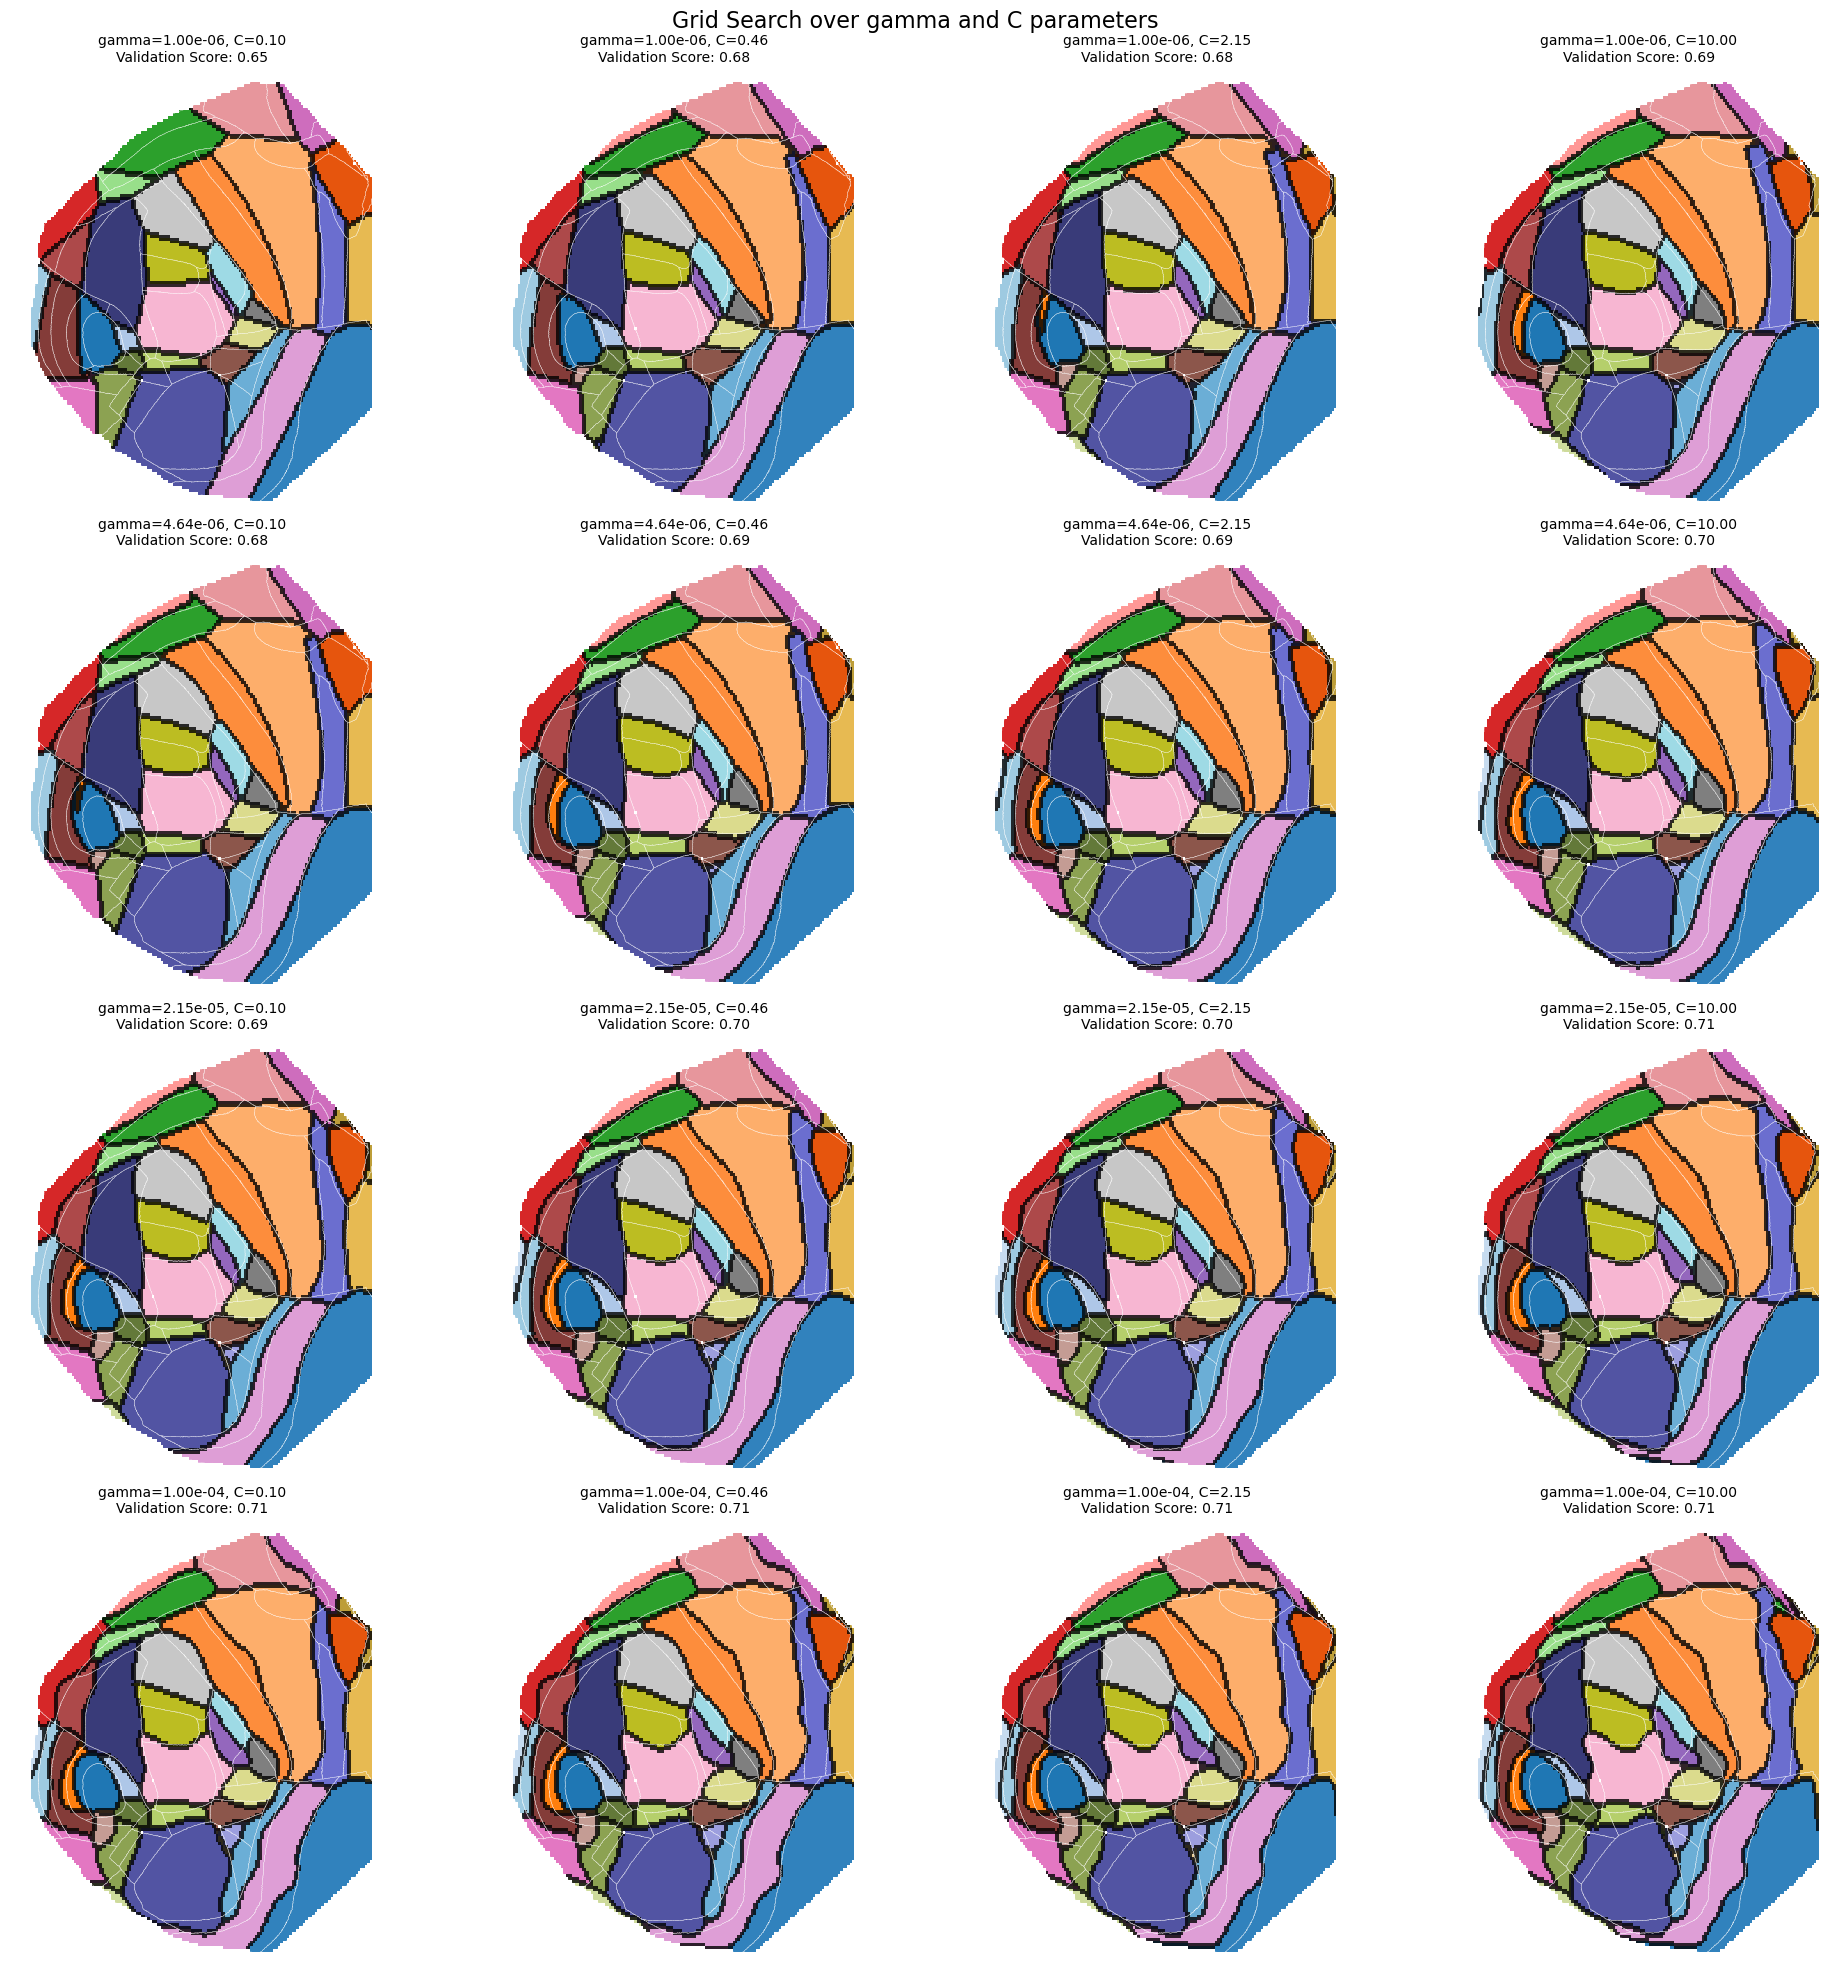

In [20]:
# Define parameter ranges for grid search
gamma_range = np.logspace(-6, -4, 4)  # log range from 1e-6 to 1e-4
c_range = np.logspace(-1, 1, 4)  # log range from 0.1 to 10
s = 2  # Subsampling factor

# Create a 4x4 grid of subplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))
axes = axes.flatten()

# Iterate through parameter combinations
for i, gamma in enumerate(gamma_range):
    for j, C in enumerate(c_range):
        print(f"Training SVC with gamma={gamma:.2e}, C={C:.2f}")

        current_idx = i * 4 + j
        current_ax = axes[current_idx]
        
        # Train model with current parameters
        with SuppressOutput():
            model = SVC(
                kernel='rbf',
                gamma=gamma,
                C=C,
                class_weight=None,
                verbose=False,
            )
            model.fit(xyz[::s, :2], preds[::s])
            
            validation_score = model.score(xyz[1::s, :2], preds[1::s])
        
        # Create decision boundary plot on current subplot
        create_decision_boundary_plot(
            model, 
            xyz[::s, :2], 
            color_map, 
            ax=current_ax,  # Pass the current axis
            grid_resolution=150
        )
        
        del model

        # Add boundary lines
        for k, boundary_coords in bf_left_boundaries_flat.items():
            current_ax.plot(*boundary_coords.T, c="w", lw=0.2)
        
        # Set subplot title
        current_ax.set_title(f"gamma={gamma:.2e}, C={C:.2f}\nValidation Score: {validation_score:.2f}", fontsize=10)
        
        # Remove tick labels for cleaner appearance
        if i < 3:  # Not bottom row
            current_ax.set_xticklabels([])
        if j > 0:  # Not leftmost column
            current_ax.set_yticklabels([])

# Add a common title
plt.suptitle("Grid Search over gamma and C parameters", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Make room for suptitle

# Save the figure
output_path = f"svc_grid_search_gamma_C_subsample_{s}.png"
plt.savefig(output_path)
plt.show()

/tmp/ipykernel_677252/3704096741.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = np.vstack([plt.cm.get_cmap(cmap)(np.linspace(0, 1, 20)) for cmap in colormaps])
100%|██████████| 138/138 [01:42<00:00,  1.35it/s]


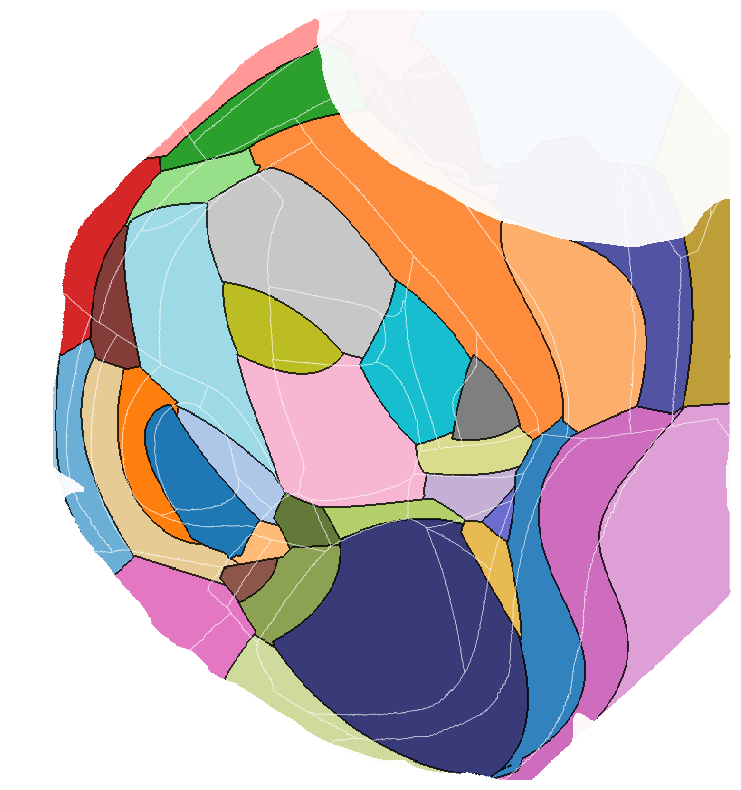

100%|██████████| 138/138 [01:39<00:00,  1.39it/s]


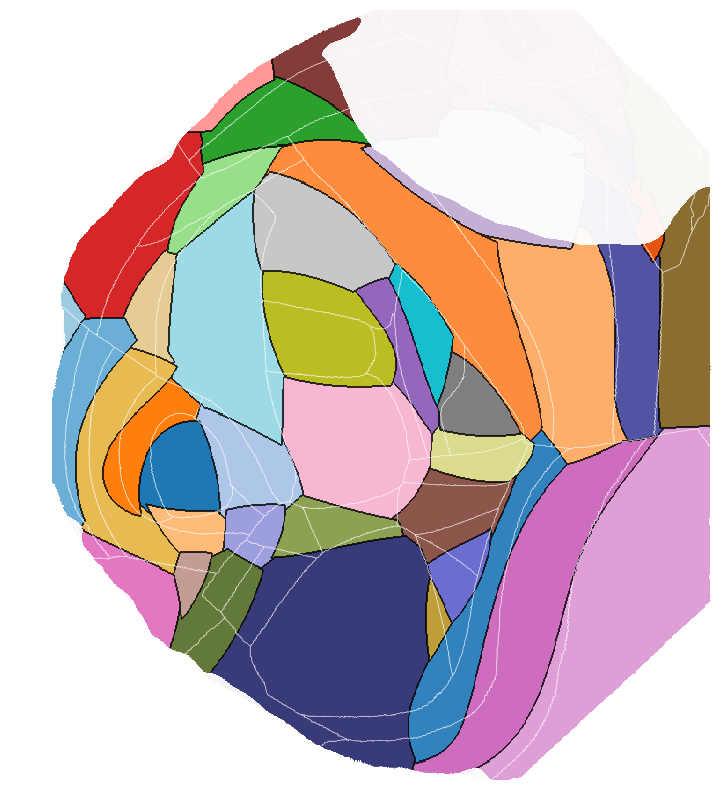

100%|██████████| 138/138 [01:59<00:00,  1.15it/s]


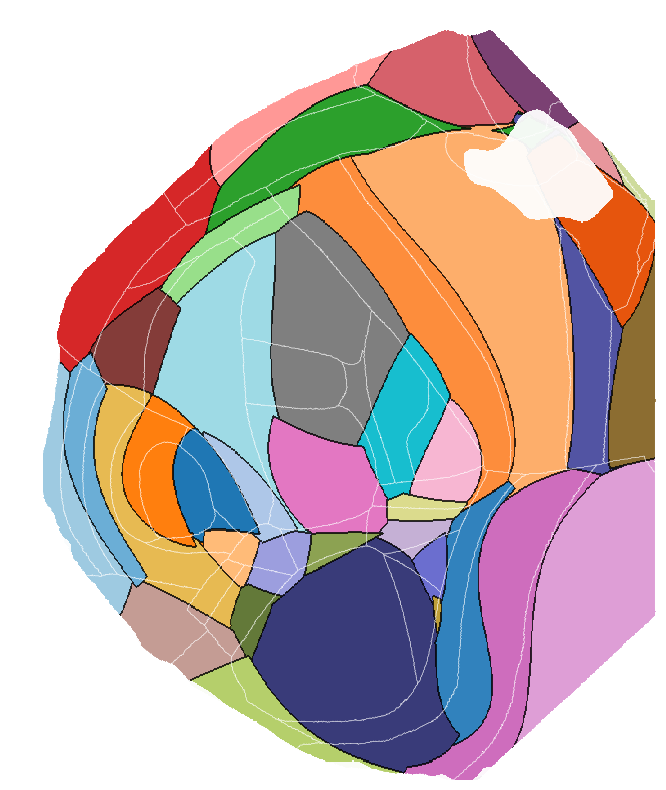

100%|██████████| 138/138 [01:53<00:00,  1.22it/s]


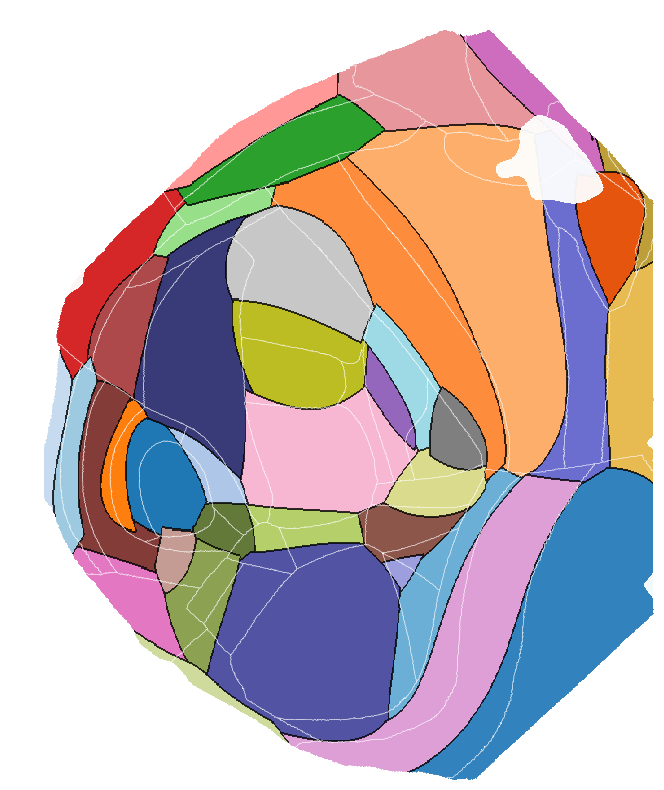

In [48]:
group_size=32
val_or_test = "test"  

color_map, label_names = create_master_colormap(range(4), group_size, val_or_test)
 
gamma = 4e-6
C=10

for fold in range(4):

    # Load data
    predictions_path = os.path.join(root_path,f"barseq/annotation/fold{fold}_animal_name_class_weights2_{group_size}/{val_or_test}_brain_predictions_cells.npy")
    pred_dict = np.load(predictions_path, allow_pickle=True).item()
    dataset = load_from_disk(os.path.join(root_path, f"barseq/Chen2023/train_test_barseq_all_exhausted_fold{fold}.dataset"))

    # Prepare data
    labels = np.array(pred_dict['labels']).flatten()
    preds = np.array(pred_dict['predictions']).flatten()
    indices = np.array(pred_dict['indices'])#[:,0].flatten()

    s=1
    xyz = np.array(dataset['train' if val_or_test == "validation" else 'test'][indices]['CCF_streamlines'])
    xyz = reflect_points_to_left(xyz)
    x, y = xyz[::s,0], xyz[::s,1]
    labels, preds = labels[::s], preds[::s]

    # Calculate accuracy
    # acc = (preds == labels).sum() / len(labels)
    # print("Accuracy", 100*acc)

    # # # Plot based on style
    # fig, ax = plot_scatter_style(x, y, labels, preds, color_map, bf_left_boundaries_flat,.1)
    # plt.savefig(f'fold{fold}_test_enucleated_single-cell-preds-{val_or_test}-{group_size}.png', dpi=300)
    # plt.show()
  
    # Train model with current parameters
    with SuppressOutput():
        model = SVC(
            kernel='rbf',
            gamma=gamma,
            C=C,
            class_weight=None,
            verbose=False,
        )
        model.fit(xyz[::s, :2], preds[::s])
        
    
    # Create decision boundary plot on current subplot
    current_ax = create_decision_boundary_plot_with_density_mask(
        model, 
        xyz[::s, :2], 
        color_map, 
        grid_resolution=750,
        density_bandwidth=15,
        batch_size=4096,
        density_mask_alpha=.95,
        density_threshold=.04,
        subsample=2
    )
    
    del model

    # Add boundary lines
    for k, boundary_coords in bf_left_boundaries_flat.items():
        current_ax.plot(*boundary_coords.T, c="w", lw=0.25)
        
    # save
    plt.tight_layout()
    plt.savefig(f"fold{fold}_svc_annotation_masked.png")
    plt.show()


In [25]:

with SuppressOutput():
    model = SVC(
        kernel='rbf',
        gamma=gamma,
        C=C,
        class_weight=None,
        verbose=False,
    )
    model.fit(xyz[::s, :2], preds[::s])
    


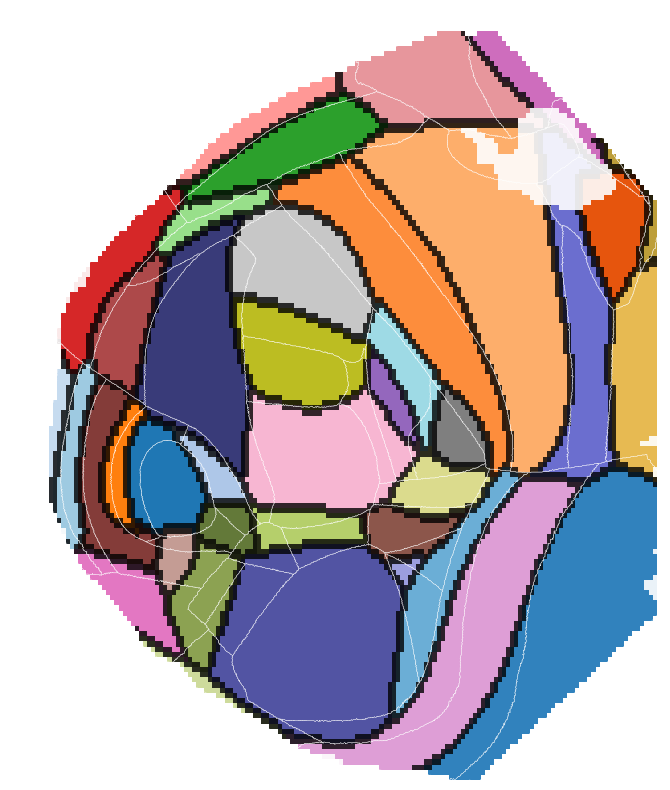

In [34]:
# Create decision boundary plot on current subplot
current_ax = create_decision_boundary_plot_with_density_mask(
    model, 
    xyz[::8, :2], 
    color_map, 
    grid_resolution=150,
    density_bandwidth=10
)

# Add boundary lines
for k, boundary_coords in bf_left_boundaries_flat.items():
    current_ax.plot(*boundary_coords.T, c="w", lw=0.25)
    
# save
plt.tight_layout()